In [1]:
from khammash_repro import ode_fun, get_init_cond, lambda_p_fun, integrate_OL
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

To find L where both strains grow:

In [5]:
def get_steady_state_fsolve(x, L):
    input = np.hstack((x, np.array([0.5])))
    ode_out = ode_fun(0, input, L)
    return ode_out[:-1]

def get_steady_state(L):
    x_guess = [1500, 100, 1000]
    ss, infodict, ier, mesg = fsolve(get_steady_state_fsolve, x_guess, args=(L,), xtol=1e-10, full_output=True, factor=0.01)
    return ss

def L_equal_fsolve(x):
    init_cond = get_init_cond(L0=x)
    init_cond[-1] = 0.3
    ode_out = ode_fun(0, init_cond, x)
    return ode_out[-1]

def L_equal_fsolve2(x):
    init_cond = get_steady_state(x)
    init_cond = np.hstack((init_cond, np.array([0.3])))
    ode_out = ode_fun(0, init_cond, x)
    return ode_out[-1]

In [7]:
L_eq, infodict, ier, mesg = fsolve(L_equal_fsolve2, 300, xtol=1e-10, full_output=True, factor=1)
print(mesg)
print("Both strains grow equally well at L = " + str(L_eq[0]))

The solution converged.
Both strains grow equally well at L = 120.32822110124214


In [8]:
L_eq, infodict, ier, mesg = fsolve(L_equal_fsolve, 300, xtol=1e-10, full_output=True, factor=1)
print(mesg)
print("Both strains grow equally well at L = " + str(L_eq[0]))

The solution converged.
Both strains grow equally well at L = 120.32822110127209


To sweep and find stable points of ground truth ODE modelL:

In [9]:
L = np.sort(np.concatenate([np.linspace(0,800,30), L_eq]))

phi_steady = []
for L0 in L:
    if np.abs(L_eq-L0) < 10:
        init_cond = get_init_cond(L0=L0, tmax=1000)
    else:
        init_cond = get_init_cond(L0=L0)
    phi_steady.append(init_cond[-1])

phi_steady = np.array(phi_steady)

In [10]:
L_eq_arr = np.ones(20) * L_eq
phi_eq_arr = np.linspace(0, 1, len(L_eq_arr))

L_plot_steady = np.sort(np.concatenate([L, L_eq_arr]))
phi_plot_steady = np.sort(np.concatenate([phi_steady, phi_eq_arr]))

In [11]:
L_vec_arr = np.linspace(0, 800, 20)
phi_vec_arr = np.linspace(0, 1, 10)

dphi_vec = np.zeros((len(L_vec_arr), len(phi_vec_arr)))

for i, L0 in enumerate(L_vec_arr):
    for j, phi0 in enumerate(phi_vec_arr):
        init_cond = get_steady_state(L0)
        init_cond = np.hstack((init_cond, np.array([phi0])))
        ode_out = ode_fun(0, init_cond, L0)
        dphi_vec[i,j] = ode_out[-1]

# print(dphi_vec)

In [12]:
print(L_vec_arr[3])
print(L_eq)
print(dphi_vec[3,:]*10000)

126.31578947368422
[120.3282211]
[0.         0.23601042 0.41301823 0.53102344 0.59002605 0.59002605
 0.53102344 0.41301823 0.23601042 0.        ]


In [13]:
np.log(51.4294776)

3.940211502239612

In [46]:
def symlog(x):
    """ Returns the symmetric log10 value """
    return np.sign(x) * np.log10(np.abs(x)+1)

def transform(u, v):
    arrow_lengths = np.sqrt(u*u + v*v)
    # len_adjust_factor = np.log10(arrow_lengths + 1) / arrow_lengths
    len_adjust_factor = np.log10(np.abs(arrow_lengths+1)) / arrow_lengths
    return u*len_adjust_factor, v*len_adjust_factor


/tmp/ipykernel_2505941/836158580.py:48: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)
/tmp/ipykernel_2505941/2979105797.py:8: RuntimeWarning: invalid value encountered in divide
  len_adjust_factor = np.log10(np.abs(arrow_lengths+1)) / arrow_lengths


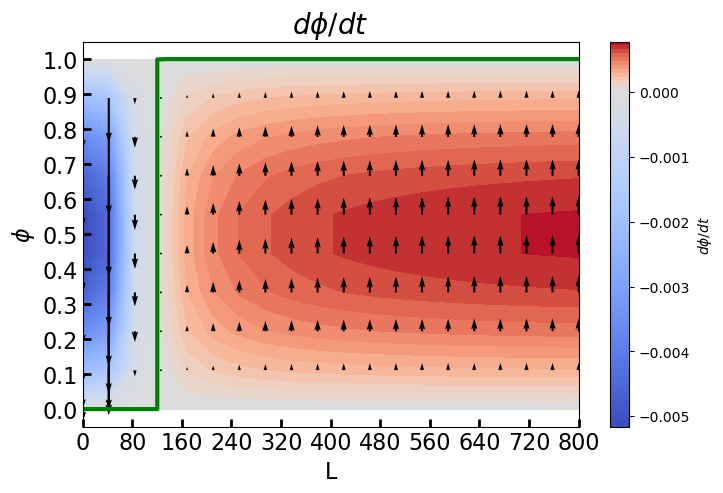

In [47]:
import matplotlib

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

newcmap = shiftedColorMap(matplotlib.cm.coolwarm, midpoint=1-np.max(dphi_vec)/(np.max(dphi_vec)-np.min(dphi_vec)))
angles=np.arctan2(dphi_vec.T,np.zeros_like(dphi_vec.T))*180.0/np.pi
U2, V2 = transform(np.zeros_like(dphi_vec.T), dphi_vec.T)

L_vec_mesh, phi_vec_mesh = np.meshgrid(L_vec_arr, phi_vec_arr)
cax = ax.contourf(L_vec_arr, phi_vec_arr, dphi_vec.T, 100, cmap= newcmap)

ax.quiver(L_vec_mesh, phi_vec_mesh, U2, V2)
# ax.quiver(L_vec_mesh, phi_vec_mesh, np.zeros_like(dphi_vec.T), dphi_vec.T)

ax.plot(L_plot_steady, phi_plot_steady, linewidth=3, color='green')
ax.set_xlabel('L', fontsize=16)
ax.set_ylabel(r'$\phi$', fontsize=16)
ax.set_title(r'$d\phi/dt$', fontsize=20)
ax.set_ylim([-0.05, 1.05])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.tick_params(axis='both', which='major', labelsize=16, width=2, length=6, direction='in')
ax.set_xticks([0, 80, 160, 240, 320, 400, 480, 560, 640, 720, 800])
fig.colorbar(cax, ticks=[-0.005, -0.004, -0.003, -0.002, -0.001, 0.000, 0.001], label=r'$d\phi/dt$')
